In [1]:
# import pandas as pd
# import os
# import random
# import os
# import math
# import numpy as np

# from PIL import Image
# from skimage import io
# from skimage import exposure
# import numpy as np

# import os
# import cv2
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import random
# from sklearn.utils import shuffle
# from tqdm import tqdm_notebook
# import warnings
# warnings.filterwarnings('ignore')
# from imutils import paths
# import cv2

# %matplotlib inline

In [2]:
# trainLabels = pd.read_csv("D:\\diabetic-retinopathy-detection\\train\\trainLabels.csv")
# trainLabels.head()

In [3]:
# listing = os.listdir("D:\\diabetic-retinopathy-detection\\train\\train")

In [4]:
# !mkdir D:\\diabetic-retinopathy-detection\\train\\train\\0
# !mkdir D:\\diabetic-retinopathy-detection\\train\\train\\1
# !mkdir D:\\diabetic-retinopathy-detection\\train\\train\\2
# !mkdir D:\\diabetic-retinopathy-detection\\train\\train\\3
# !mkdir D:\\diabetic-retinopathy-detection\\train\\train\\4

In [5]:
# base_dir = "D:\\diabetic-retinopathy-detection\\train\\train\\"
# for file in listing:
#     try:
#         fileName = os.path.splitext(file)[0]
#         folder_name = trainLabels.loc[trainLabels.image==fileName, 'level'].values[0]
#         print(fileName)
#         print(folder_name)
#         os.rename(base_dir + file, base_dir + str(folder_name) + "\\" + file )
#     except:
#         print("Error naming file")
#         pass

In [6]:
import numpy as np
import pandas as pd
import os
import random
import sys
import cv2
import matplotlib
from subprocess import check_output
import warnings
warnings.filterwarnings('ignore')

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Using TensorFlow backend.


In [8]:
def classes_to_int(label):
    label = label.strip()
    if label == "No DR":  return 0
    if label == "Mild":  return 1
    if label == "Moderate":  return 2
    if label == "Severe":  return 3
    if label == "Proliferative DR":  return 4
    print("Invalid Label", label)
    return 5

In [9]:
def int_to_classes(i):
    if i == 0: return "No DR"
    elif i == 1: return "Mild"
    elif i == 2: return "Moderate"
    elif i == 3: return "Severe"
    elif i == 4: return "Proliferative DR"
    print("Invalid class ", i)
    return "Invalid Class"

In [10]:
NUM_CLASSES = 5
WIDTH = 128
HEIGHT = 128
DEPTH = 3
inputShape = (HEIGHT, WIDTH, DEPTH)
EPOCHS = 150
INIT_LR = 1e-3
BS = 32
ImageNameDataHash = {}
uniquePatientIDList = []

In [11]:
global ImageNameDataHash
trainDir= "D:\\subset_data\\train"
images = os.listdir(trainDir)
print("Number of files in " + trainDir + " is " + str(len(images)))

Number of files in D:\subset_data\train is 892


In [12]:
for imageFileName in images:
    if (imageFileName == "trainLabels.csv"):
        continue
    imageFullPath = os.path.join('/', trainDir, imageFileName)
    img = load_img(imageFullPath)
    arr = img_to_array(img)  
    dim1 = arr.shape[0]
    dim2 = arr.shape[1]
    dim3 = arr.shape[2]
    if (dim1 < HEIGHT or dim2 < WIDTH or dim3 < DEPTH):
        print("Error image dimensions are less than expected "+str(arr.shape))
    arr = cv2.resize(arr, (HEIGHT,WIDTH))
    dim1 = arr.shape[0]
    dim2 = arr.shape[1]
    dim3 = arr.shape[2]
    if (dim1 != HEIGHT or dim2 != WIDTH or dim3 != DEPTH):
        print("Error after resize, image dimensions are not equal to expected "+str(arr.shape))
    arr = np.array(arr, dtype="float") / 255.0
    imageFileName = imageFileName.replace('.jpeg','')
    ImageNameDataHash[str(imageFileName)] = np.array(arr) 

In [13]:
import csv
raw_df = pd.read_csv('D:\\subset_data\\trainLabels.csv', sep=',')
print(type(raw_df))

<class 'pandas.core.frame.DataFrame'>


In [14]:
row_count=raw_df.shape[0]
col_count=raw_df.shape[1]
print("row_count="+str(row_count)+" col count="+str(col_count))
raw_df["PatientID"] = ''
header_list = list(raw_df.columns)
print(header_list)

row_count=35126 col count=2
['image', 'level', 'PatientID']


In [15]:
ImageLevelHash = {}
patientIDList = []
for index, row in raw_df.iterrows():
    key = row[0] + ''
    patientID = row[0] + ''
    patientID = patientID.replace('_right','')
    patientID = patientID.replace('_left','')
    raw_df.at[index, 'PatientID'] = patientID
    patientIDList.append(patientID)
    ImageLevelHash[key] = str(row[1])       

In [16]:
global uniquePatientIDList
uniquePatientIDList = sorted(set(patientIDList))
count=0;
for patientID in uniquePatientIDList:
    left_level = ImageLevelHash[str(patientID+'_left')]
    right_level = ImageLevelHash[str(patientID+'_right')]
    if (left_level != right_level):
        count = count+1
print("count of images with both left and right eye level not matching="+str(count))
print("number of unique patients="+str(len(uniquePatientIDList)))

count of images with both left and right eye level not matching=2240
number of unique patients=17563


In [17]:
for i in range(0,10):
    s = raw_df.loc[raw_df.index[i], 'PatientID']
    print(str(i) + " patient's patientID="+str(s))

0 patient's patientID=10
1 patient's patientID=10
2 patient's patientID=13
3 patient's patientID=13
4 patient's patientID=15
5 patient's patientID=15
6 patient's patientID=16
7 patient's patientID=16
8 patient's patientID=17
9 patient's patientID=17


In [18]:
keepImages =  list(ImageNameDataHash.keys())
raw_df = raw_df[raw_df['image'].isin(keepImages)]
print(len(raw_df)) # 1000

891


In [19]:
imageNameArr = []
dataArr = []
for index, row in raw_df.iterrows():
    key = str(row[0])
    if key in ImageNameDataHash:
        imageNameArr.append(key)
        dataArr.append(np.array(ImageNameDataHash[key]))
df2 = pd.DataFrame({'image': imageNameArr, 'data': dataArr})
df2_header_list = list(df2.columns) 
print(df2_header_list)
print(len(df2))

['image', 'data']
891


In [20]:
if len(raw_df) != len(df2):
    print("Error length of df != df2")
    
for idx in range(0,len(raw_df)):
    if (raw_df.loc[raw_df.index[idx], 'image'] != df2.loc[df2.index[idx], 'image']):
        print("Error " + raw_df.loc[raw_df.index[idx], 'image'] +"==" + df2.loc[df2.index[idx], 'image'])
        
print(df2.dtypes)
print(raw_df.dtypes)

image    object
data     object
dtype: object
image        object
level         int64
PatientID    object
dtype: object


In [21]:
df = raw_df

In [22]:
df = pd.merge(df2, df, left_on='image', right_on='image', how='outer')
df_header_list = list(df.columns) 
print(df_header_list)
print(len(df))
print(df.sample())

['image', 'data', 'level', 'PatientID']
891
          image                                               data  level  \
803  15636_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      2   

    PatientID  
803     15636  


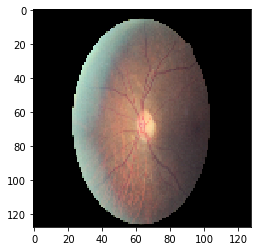

The label 0
Sample Image


In [23]:
sample0 = df.loc[0, 'data']
from matplotlib import pyplot as plt
plt.imshow(sample0, interpolation='nearest')
plt.show()
print("The label",df.loc[0,"level"])
print("Sample Image")

In [24]:
X = df['data']
Y = df['level']
Y = np.array(Y)
Y =  to_categorical(Y, num_classes=NUM_CLASSES)

In [25]:
print("Parttition data into 75:25...")
sys.stdout.flush()
print("Unique patients in dataframe df=" + str(df.PatientID.nunique()))
unique_ids = df.PatientID.unique()
print('unique_ids shape='+ str(len(unique_ids)))

train_ids, valid_ids = train_test_split(unique_ids, test_size = 0.20, random_state = 10) 
trainid_list = train_ids.tolist()
print('trainid_list shape=', str(len(trainid_list)))

traindf = df[df.PatientID.isin(trainid_list)]
valSet = df[~df.PatientID.isin(trainid_list)]

Parttition data into 75:25...
Unique patients in dataframe df=509
unique_ids shape=509
trainid_list shape= 407


In [26]:
traindf = traindf.reset_index(drop=True)
valSet = valSet.reset_index(drop=True)

print(traindf.head())
print(valSet.head())

      image                                               data  level  \
0   10_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0   
1  10_right  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0   
2   15_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      1   
3  15_right  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      2   
4   16_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      4   

  PatientID  
0        10  
1        10  
2        15  
3        15  
4        16  
      image                                               data  level  \
0   13_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0   
1  13_right  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0   
2   20_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0   
3  20_right  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0   
4   21_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0   

  PatientID  
0        13  
1        1

In [27]:
trainX = traindf['data']
trainY = traindf['level']
valX = valSet['data']
valY = valSet['level']
print('trainX shape=', trainX.shape[0], 'valX shape=', valX.shape[0])

trainX shape= 714 valX shape= 177


In [28]:
trainY =  to_categorical(trainY, num_classes=NUM_CLASSES)
valY =  to_categorical(valY, num_classes=NUM_CLASSES)

In [29]:
print("Generating images...")
sys.stdout.flush()
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, \
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,\
    horizontal_flip=True, fill_mode="nearest")

Generating images...


In [30]:
def createModel():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=inputShape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_dim=NUM_CLASSES, activation='softmax'))
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [31]:
import datetime
print("Reshaping trainX at..."+ str(datetime.datetime.now()))
print(type(trainX))
print(trainX.shape)
from numpy import zeros
Xtrain = np.zeros([trainX.shape[0],HEIGHT, WIDTH, DEPTH])
for i in range(trainX.shape[0]): 
    Xtrain[i] = trainX[i]
print(Xtrain.shape)
print("Reshaped trainX at..."+ str(datetime.datetime.now()))

Reshaping trainX at...2020-03-03 21:02:34.688618
<class 'pandas.core.series.Series'>
(714,)
(714, 128, 128, 3)
Reshaped trainX at...2020-03-03 21:02:34.910490


In [32]:
print("Reshaping valX at..."+ str(datetime.datetime.now()))
print(type(valX))
print(valX.shape) 
from numpy import zeros
Xval = np.zeros([valX.shape[0],HEIGHT, WIDTH, DEPTH])
for i in range(valX.shape[0]): 
    Xval[i] = valX[i]
print(Xval.shape)
print("Reshaped valX at..."+ str(datetime.datetime.now()))

Reshaping valX at...2020-03-03 21:02:34.919485
<class 'pandas.core.series.Series'>
(177,)
(177, 128, 128, 3)
Reshaped valX at...2020-03-03 21:02:34.978452


In [33]:
print("compiling model...")
sys.stdout.flush()
model = createModel()

compiling model...


In [34]:
from keras.utils import print_summary
print_summary(model, line_length=None, positions=None, print_fn=None)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [35]:
from contextlib import redirect_stdout
with open('D:\\subset_data\\modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

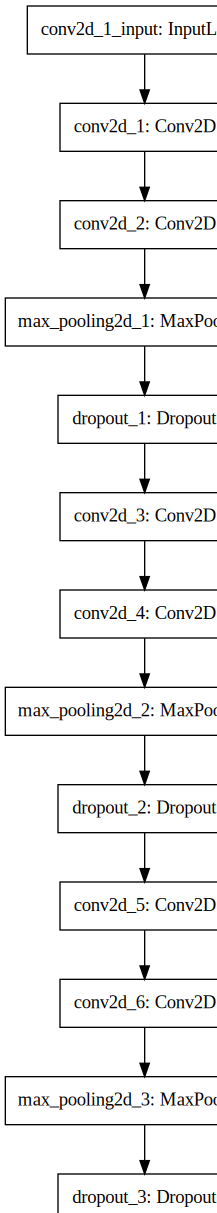

In [36]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

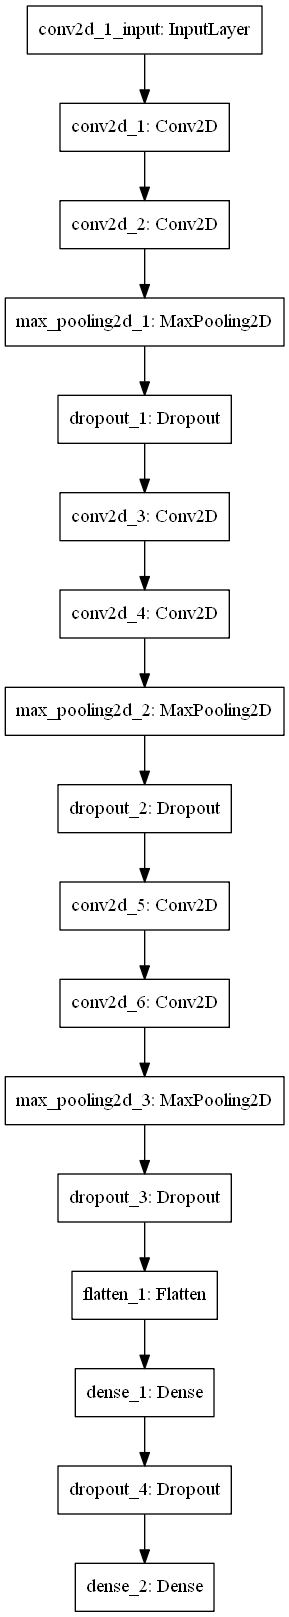

In [37]:
from keras.utils import plot_model
plot_model(model, to_file='D:\\subset_data\\plotofmodel.png')

In [ ]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('D:\\subset_data\\training.csv', append=True)

In [38]:
print("training network...")
sys.stdout.flush()

H = model.fit_generator(aug.flow(Xtrain, trainY, batch_size=BS), \
    validation_data=(Xval, valY), \
    steps_per_epoch=len(trainX) // BS, \
    epochs=EPOCHS, verbose=1,callbacks=[csv_logger])

training network...
Epoch 1/150
22/22 [==============================] - 72s 3s/step - loss: 1.4609 - accuracy: 0.3695 - val_loss: 1.3614 - val_accuracy: 0.4689
Epoch 2/150
22/22 [==============================] - 78s 4s/step - loss: 1.4073 - accuracy: 0.3878 - val_loss: 1.3351 - val_accuracy: 0.4915
Epoch 3/150
22/22 [==============================] - 65s 3s/step - loss: 1.3774 - accuracy: 0.4045 - val_loss: 1.3323 - val_accuracy: 0.4633
Epoch 4/150
22/22 [==============================] - 72s 3s/step - loss: 1.3900 - accuracy: 0.4120 - val_loss: 1.2986 - val_accuracy: 0.4633
Epoch 5/150
22/22 [==============================] - 81s 4s/step - loss: 1.3739 - accuracy: 0.3827 - val_loss: 1.3506 - val_accuracy: 0.4915
Epoch 6/150
22/22 [==============================] - 73s 3s/step - loss: 1.4329 - accuracy: 0.4135 - val_loss: 1.3265 - val_accuracy: 0.4633
Epoch 7/150
22/22 [==============================] - 73s 3s/step - loss: 1.3608 - accuracy: 0.4003 - val_loss: 1.3140 - val_accuracy: 

In [39]:
import pickle

# save:
f = open('D:\\subset_data\\history.pckl', 'wb')
pickle.dump(H.history, f)
f.close()

In [40]:
# keras library import  for Saving and loading model and weights
print("Saving model to disk")
sys.stdout.flush()

from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()


with open("D:\\subset_data\\model_num.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("D:\\subset_data\\model_num.h5")

Saving model to disk


Generating plots...


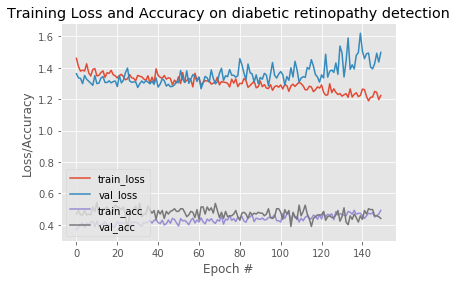

In [41]:
print("Generating plots...")
sys.stdout.flush()
matplotlib.use("Agg")
matplotlib.pyplot.style.use("ggplot")
matplotlib.pyplot.figure()
N = EPOCHS
matplotlib.pyplot.plot(np.arange(0, N), H.history["loss"], label="train_loss")
matplotlib.pyplot.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
matplotlib.pyplot.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
matplotlib.pyplot.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
matplotlib.pyplot.title("Training Loss and Accuracy on diabetic retinopathy detection")
matplotlib.pyplot.xlabel("Epoch #")
matplotlib.pyplot.ylabel("Loss/Accuracy")
matplotlib.pyplot.legend(loc="lower left")
matplotlib.pyplot.savefig("D:\\subset_data\\plot.png")

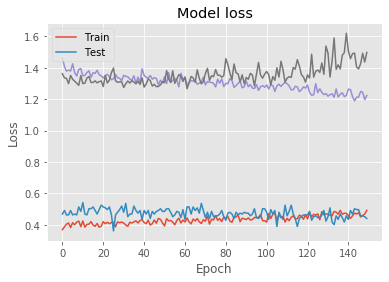

In [42]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt

plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig("D:\\subset_data\\plot_accuracy.png")

# Plot training & validation loss values
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig("D:\\subset_data\\plot_loss.png")

In [43]:
rm = model.predict(Xtrain)
k=[]
d= {}
for i in range(len(rm)):
    d[np.argmax(trainY[i])] = d.get(np.argmax(trainY[i]),0)+1
    k.append((np.argmax(rm[i]),np.argmax(trainY[i])))

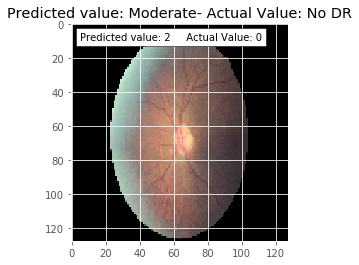

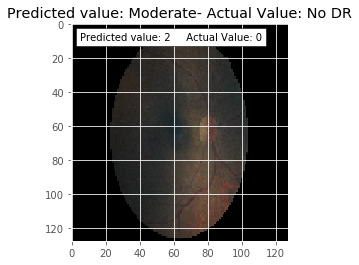

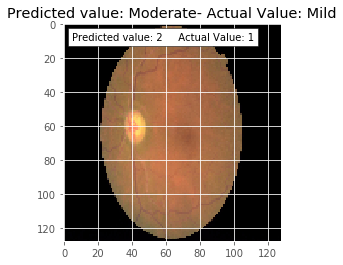

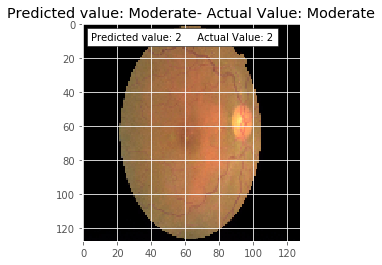

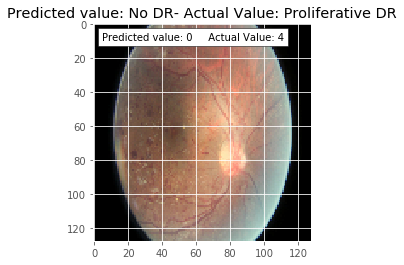

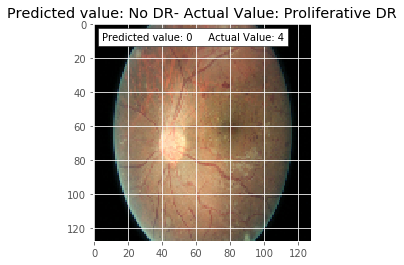

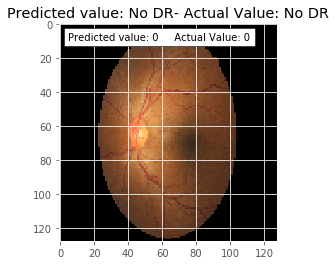

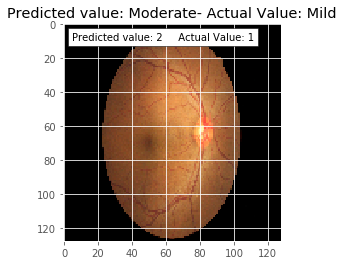

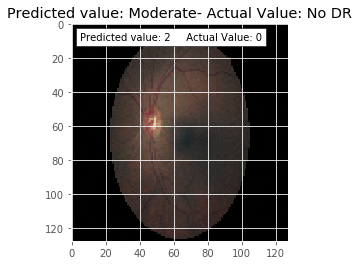

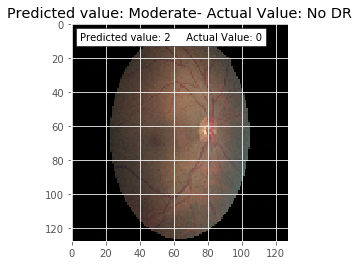

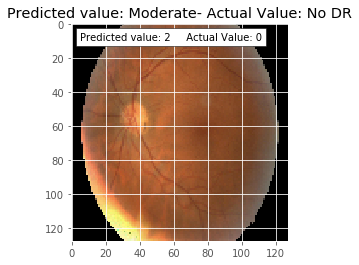

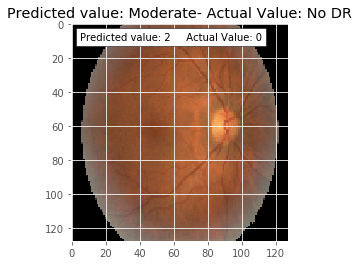

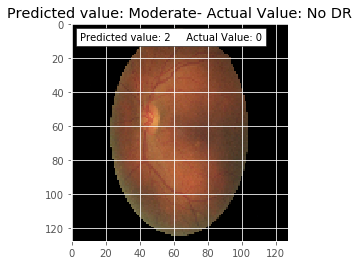

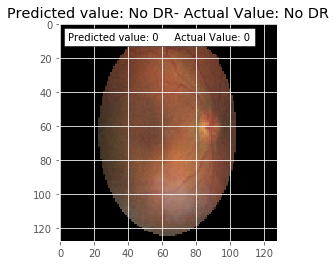

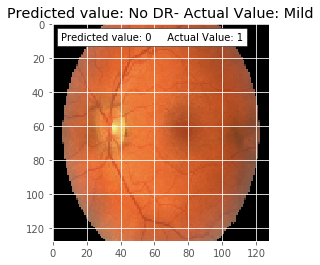

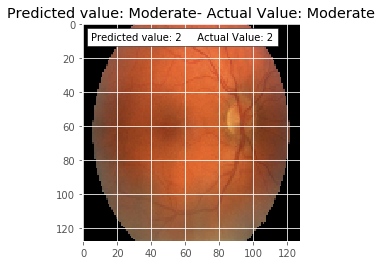

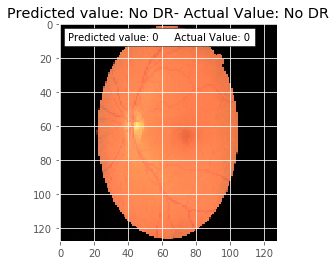

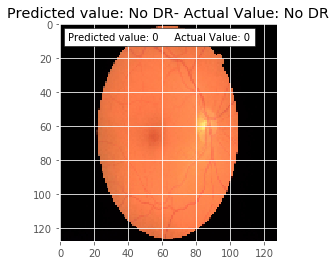

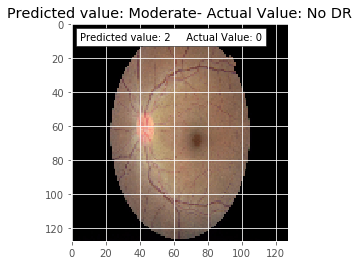

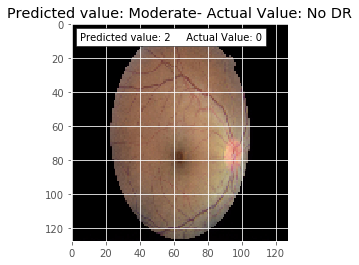

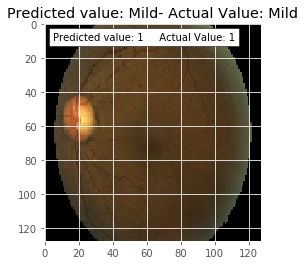

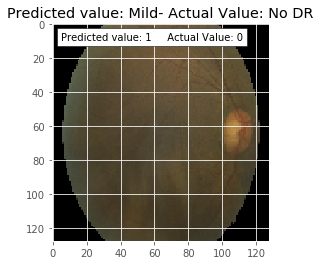

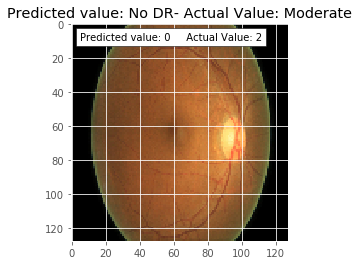

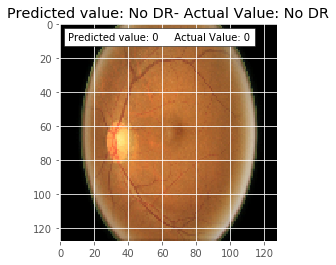

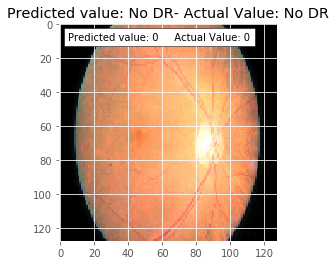

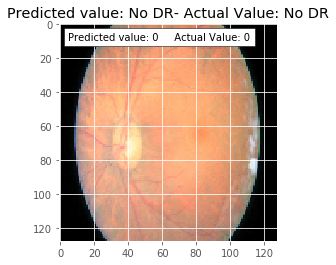

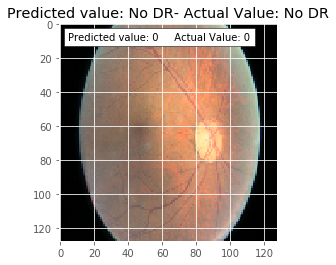

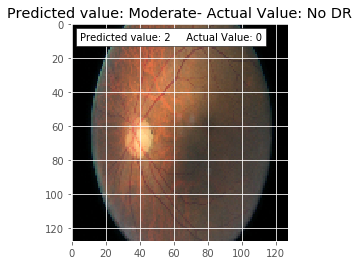

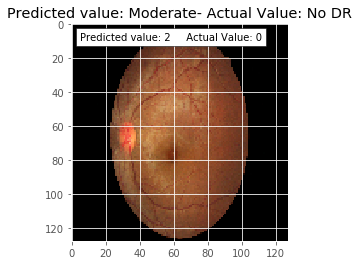

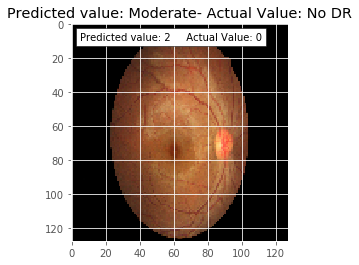

In [44]:
%matplotlib inline
from matplotlib.offsetbox import AnchoredText
for i in range(30):
    f, ax = plt.subplots(1,1)
    anchored_text = AnchoredText("Predicted value: "+str((k[i][0]))+"     Actual Value: "+str((k[i][1]))+"", loc=2)
    plt.imshow(Xtrain[i],label='sdd' )
    ax.set_title("Predicted value: "+str(int_to_classes(k[i][0]))+"- Actual Value: "+str(int_to_classes(k[i][1]))+"")
    ax.add_artist(anchored_text)
    plt.show()
    f.savefig("D:\\subset_data\\result"+str(i)+".png")

In [45]:
print("DONE")

DONE


In [46]:
# retrieve:    
f = open('D:\\subset_data\\history.pckl', 'rb')
history = pickle.load(f)
f.close()

In [47]:
# load json and create model
json_file = open('D:\\subset_data\\model_num.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("D:\\subset_data\\model_num.h5")
print("Loaded model from disk")

loaded_model.save('D:\\subset_data\\model_num.hdf5')
nloaded_model=load_model('D:\\subset_data\\model_num.hdf5')

Loaded model from disk


In [48]:
# rm = loaded_model.predict(Xtrain)
# k=[]
# d= {}
# for i in range(len(rm)):
#     d[np.argmax(trainY[i])] = d.get(np.argmax(trainY[i]),0)+1
#     k.append((np.argmax(rm[i]),np.argmax(trainY[i])))

In [49]:
# %matplotlib inline
# from matplotlib.offsetbox import AnchoredText
# for i in range(30):
#     f, ax = plt.subplots(1,1)
#     anchored_text = AnchoredText("Predicted value: "+str((k[i][0]))+"     Actual Value: "+str((k[i][1]))+"", loc=2)
#     plt.imshow(Xtrain[i],label='sdd' )
#     ax.set_title("Predicted value: "+str(int_to_classes(k[i][0]))+" Actual Value: "+str(int_to_classes(k[i][1]))+"")
#     ax.add_artist(anchored_text)
#     plt.show()
#     f.savefig("D:\\subset_data\\"+str(i)+'plot.png')

In [50]:
print(history)

{'val_loss': [1.3613683099800584, 1.3351306625678714, 1.332323361251314, 1.29860204289862, 1.3505818129932814, 1.3264590939559506, 1.3139597494049935, 1.3014199770776564, 1.287818100492833, 1.3500822230247453, 1.2990745885223993, 1.301502423771357, 1.3344586481482297, 1.3434282797204573, 1.3058944307478135, 1.3058409556157171, 1.3163040216359716, 1.3034610707881087, 1.3115750692658505, 1.3154000158363817, 1.2800268231138672, 1.3501887334942144, 1.3030564481929197, 1.3213139718535256, 1.3685953630565924, 1.397427162208126, 1.3167564195428192, 1.3070779466359628, 1.3091453778541695, 1.3097103578222673, 1.2742182817836265, 1.2979468241923273, 1.3155626186543266, 1.3022291815213565, 1.317736613548408, 1.3087768608567405, 1.297367828713972, 1.3144733616187747, 1.293840345689806, 1.3349371569304815, 1.2766122009794592, 1.2960546764276795, 1.3285163890170513, 1.317957827600382, 1.2830792342202137, 1.2940286606718592, 1.2789172472926857, 1.2809744911678766, 1.2906697146636619, 1.31103598465353

In [52]:
csv_logger = CSVLogger('D:\\subset_data\\epochs_training.csv', append=True)

In [56]:
f =  open('D:\\subset_data\\epochs_accuracy.txt', 'w+')

In [55]:
for epoch in (1,5,10,30):
    hist = model.fit_generator(aug.flow(Xtrain, trainY, batch_size=100), \
    validation_data=(Xval, valY), \
    steps_per_epoch=len(trainX) // 100, \
    epochs=epoch, verbose=1, callbacks=[csv_logger])
    f.write("\n____________________________________________________________________________\n")
    f.write("Iteration - %s\n " % str(epoch))
    f.write("Train Accuray - %s\n "% str(hist.history["accuracy"][-1]))
    f.write("Test Accuray - %s\n "% str(hist.history["val_accuracy"][-1]))
    f.write("\n____________________________________________________________________________\n")

Epoch 1/1
7/7 [==============================] - 47s 7s/step - loss: 1.2448 - accuracy: 0.5016 - val_loss: 1.4154 - val_accuracy: 0.4915
Epoch 1/5
7/7 [==============================] - 55s 8s/step - loss: 1.1897 - accuracy: 0.5147 - val_loss: 1.3629 - val_accuracy: 0.5085
Epoch 2/5
7/7 [==============================] - 56s 8s/step - loss: 1.1582 - accuracy: 0.4772 - val_loss: 1.4171 - val_accuracy: 0.4859
Epoch 3/5
7/7 [==============================] - 56s 8s/step - loss: 1.1573 - accuracy: 0.5214 - val_loss: 1.4167 - val_accuracy: 0.5085
Epoch 4/5
7/7 [==============================] - 44s 6s/step - loss: 1.1404 - accuracy: 0.4981 - val_loss: 1.4831 - val_accuracy: 0.4802
Epoch 5/5
7/7 [==============================] - 56s 8s/step - loss: 1.1567 - accuracy: 0.4914 - val_loss: 1.4785 - val_accuracy: 0.4520
Epoch 1/10
7/7 [==============================] - 51s 7s/step - loss: 1.1677 - accuracy: 0.5130 - val_loss: 1.4428 - val_accuracy: 0.4576
Epoch 2/10
7/7 [========================